In [1]:
# Segmentation using sam
!pip install -q git+https://github.com/facebookresearch/segment-anything.git



  Preparing metadata (setup.py) ... done


In [14]:
# Import libs

import numpy as np
import matplotlib.pyplot as plt

import torch # PyTorch
from torchvision import transforms # PyTorch transforms
from torchvision.transforms.functional import to_pil_image, to_tensor
import PIL
from PIL import Image
import cv2

# Import utilities
import json, requests, copy, sys

# Import SAM libs
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


In [9]:
# Download model checkpoint

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O sam_chkpts/sam_vit_h_4b8939.pth

--2024-09-22 06:42:52--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.18.102, 13.35.18.15, 13.35.18.103, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.18.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_chkpts/sam_vit_h_4b8939.pth’

sam_chkpts/sam_vit_ 100%[===================>]   2.39G  38.4MB/s    in 21s     

2024-09-22 06:43:13 (115 MB/s) - ‘sam_chkpts/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



4032 3024
Target image size: (512, 512)


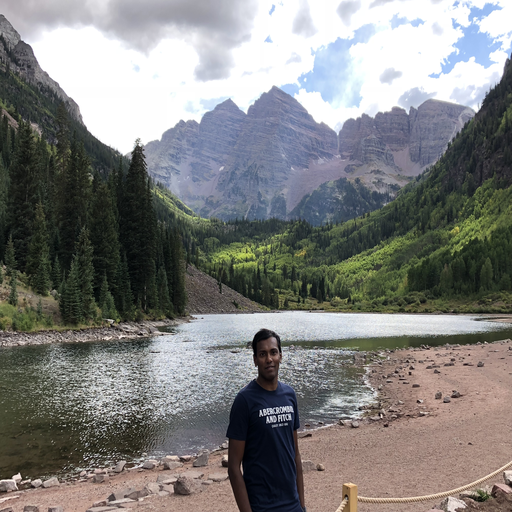

In [60]:
# Load image:

target_width = 512
target_height = 512

src_img = Image.open("aspen.jpg")

img_width, img_height = src_img.size

print(img_width, img_height)

# Crop image

src_img_cropped = src_img.crop((0, 0, img_width, img_height))
src_img_cropped_resized = src_img_cropped.resize((target_width, target_height), Image.LANCZOS )

print(f"Target image size: {src_img_cropped_resized.size}")

# Save image
src_img_cropped_resized.save("ajay_cropped.jpg")
display(src_img_cropped_resized)


In [61]:
# Convert image to array for SAM

src_img_array = np.array(src_img_cropped_resized)

print(src_img_array.shape)

(512, 512, 3)


In [62]:
# Initialize SAM model

model_type = "vit_h"
model_path = "sam_chkpts/sam_vit_h_4b8939.pth"

sam = sam_model_registry[model_type](checkpoint=model_path).to("cuda")
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.99,
    stability_score_offset=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
    )

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [64]:
# Run SAM on the image array
masks = mask_generator.generate(src_img_array)

# print len(masks), keys in masks
print(len(masks))
print(masks[0].keys())
print(masks)



9
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
[{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 10033, 'bbox': [226.0, 328.0, 78.0, 183.0], 'predicted_iou': 1.0217065811157227, 'point_coords': [[267.96875, 372.65625]], 'stability_score': 0.9871184825897217, 'crop_box': [0.0, 169.0, 343.0, 343.0]}, {'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
  

In [65]:
masks = [ mask for mask in masks if mask['area'] >= 20000 ]

In [66]:
len(masks)

3

In [67]:
# print masks and the IOUs
for i, mask in enumerate(masks):
    # Print in one line with id in a pretty way

    print(f'{i}, Area: {mask["area"]}, IOU: {mask["predicted_iou"]}')

    # print(mask['area'])
    # print(mask['predicted_iou'])

0, Area: 53236, IOU: 1.0317705869674683
1, Area: 25186, IOU: 0.997173547744751
2, Area: 42988, IOU: 1.0031559467315674


In [17]:
# funtion to visualize the masks together with a number that identifies the mask

def visualize_masks(masks, colors, borders=True) -> None:
    """
    show the annotations
    """
    # return if no masks
    if len(masks) == 0:
        return

    # sort masks by size
    sorted_annot_and_color = sorted(
        zip(masks, colors), key=(lambda x: x[0].sum()), reverse=True
    )
    H, W = sorted_annot_and_color[0][0].shape[0], sorted_annot_and_color[0][0].shape[1]

    canvas = np.ones((H, W, 4))
    canvas[:, :, 3] = 0  # set the alpha channel
    contour_thickness = max(1, int(min(5, 0.01 * min(H, W))))
    for mask, color in sorted_annot_and_color:
        canvas[mask] = np.concatenate([color, [0.55]])
        if borders:
            contours, _ = cv2.findContours(
                np.array(mask, dtype=np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
            )
            cv2.drawContours(canvas, contours, -1, color=color, thickness=contour_thickness)

    ax = plt.gca()
    ax.imshow(canvas)


In [47]:
### Declare function to visualize the masks generated together with a number that identifies each of them

def show_masks(anns):
    if len(anns) == 0:
        return

    # Sort masks by area in descending order
    sorted_anns = sorted(enumerate(anns), key=(lambda x: x[1]['area']), reverse=True)
    ax = plt.gca()

    # Disable autoscale to keep the image size consistent
    ax.set_autoscale_on(False)

    # Iterate through each mask and display it on top of the original image
    for original_idx, ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))

        # Generate a random color for the mask
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]

        # Blend the mask with the image, using 0.35 as the alpha value for transparency
        ax.imshow(np.dstack((img, m*0.35)))

        # Find contours of the mask to compute the centroid
        contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = contours[0]
            M = cv2.moments(cnt)

            # Compute the centroid of the mask if the moment is non-zero
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])

                # Display the original index number (1-based) at the centroid of the mask
                # The text is white, bold, and has a font size of 16
                ax.text(cx, cy, str(original_idx), color='white', fontsize=16, ha='center', va='center', fontweight='bold')



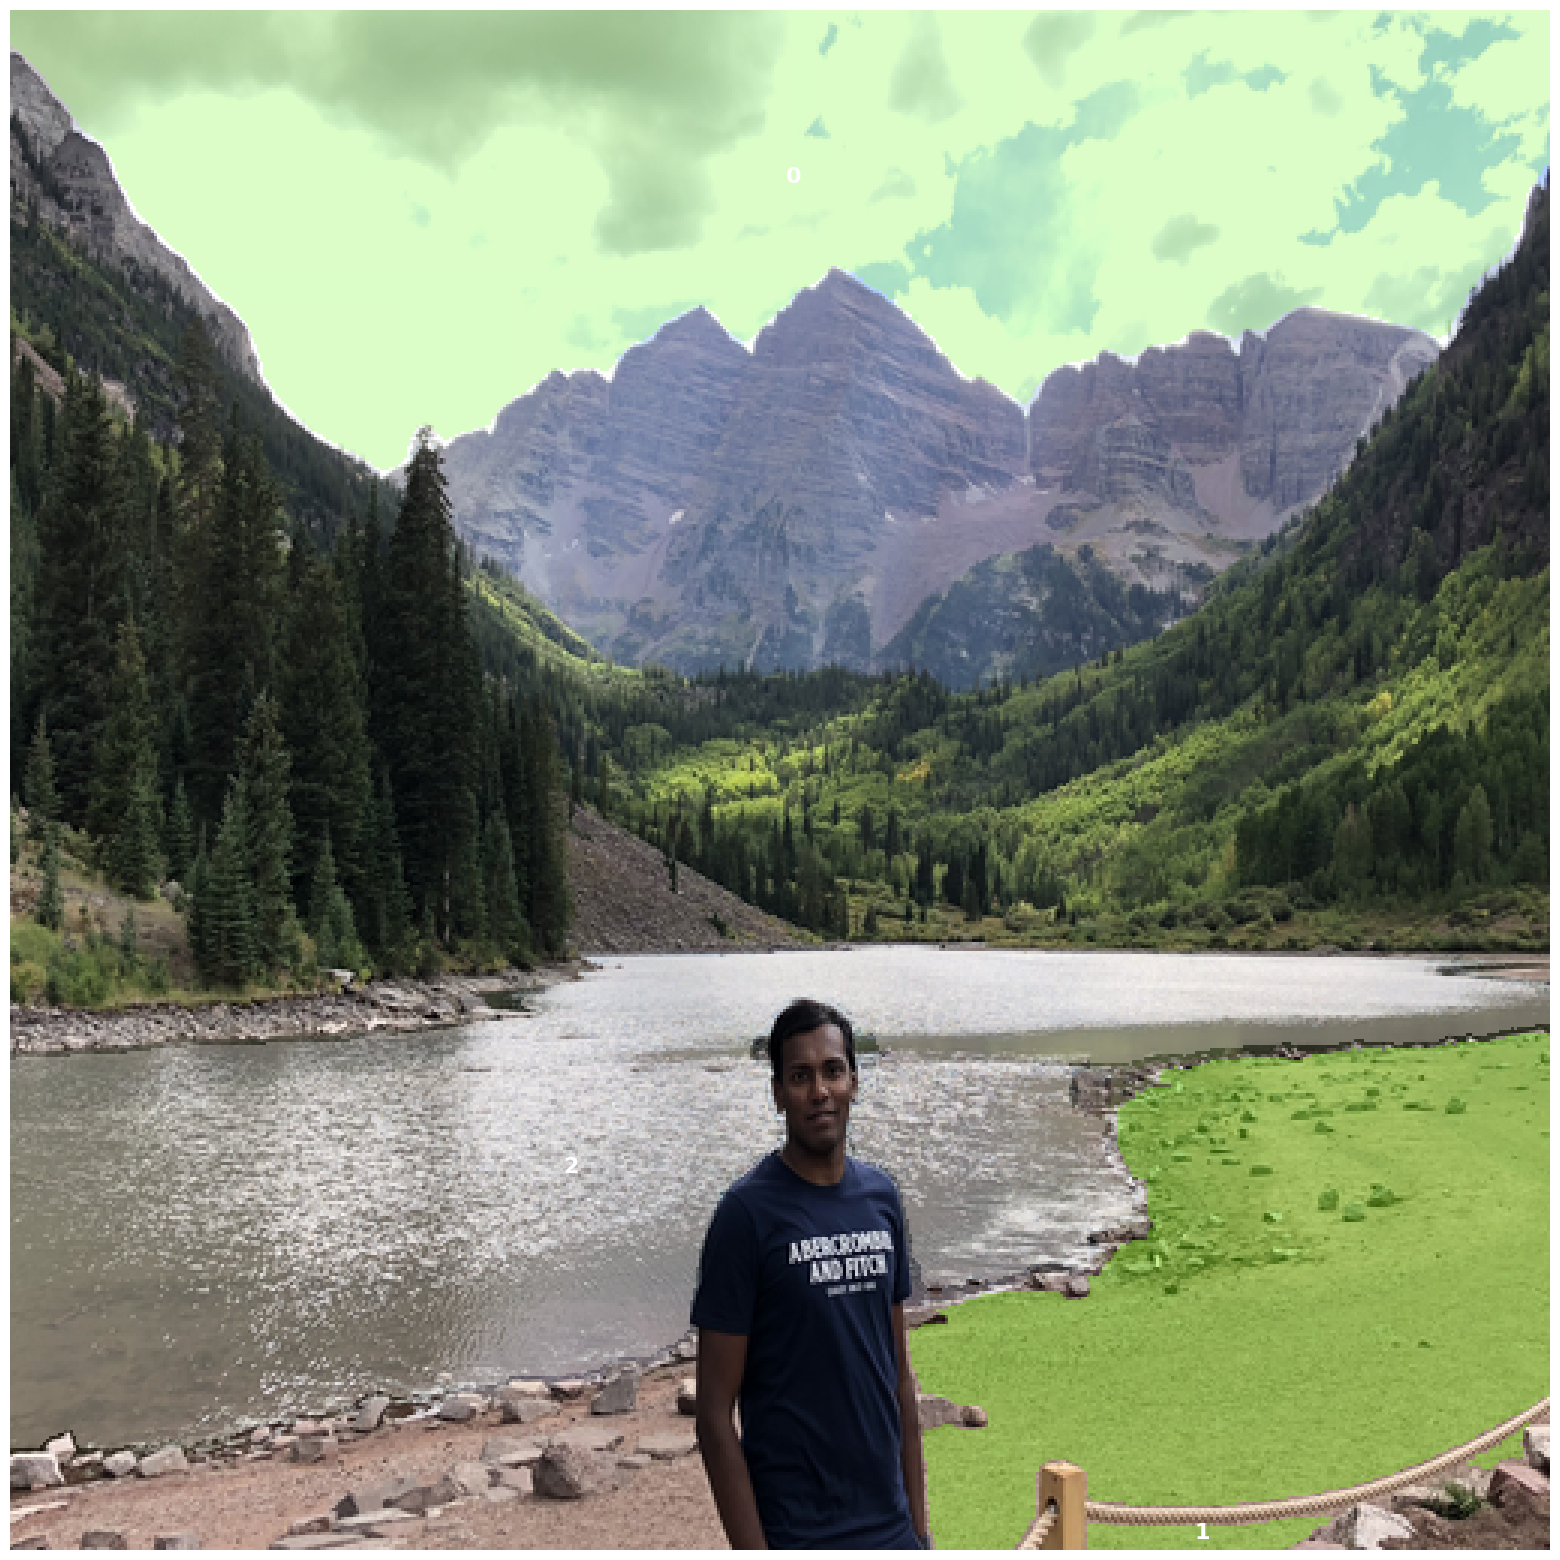

In [68]:
# Display masms in the image

plt.figure(figsize=(20,20))
plt.imshow(src_img_cropped_resized)
show_masks(masks)  # use masks[:-x] to only display the first masks of the list
plt.axis('off')
plt.show()

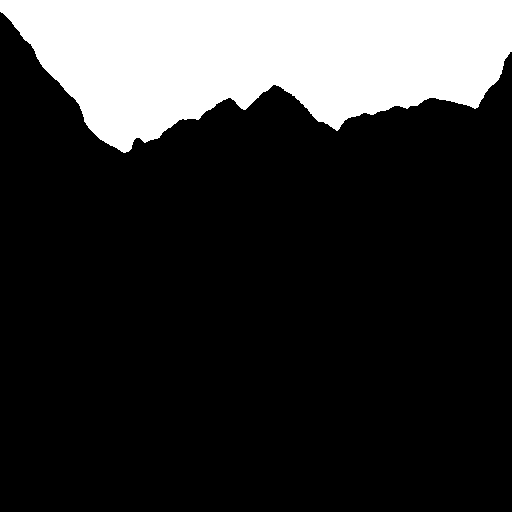

In [75]:
# select a mask index for painting
mask_id = 0


segmentation_mask = masks[mask_id]['segmentation']
mask_img = PIL.Image.fromarray((segmentation_mask))

# show the mask
display(mask_img)

In [22]:
! pip install transformers diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 52.6 MB/s eta 0:00:00


In [25]:
! pip install xformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 97.7 MB/s eta 0:00:00


In [33]:
# Create stable diffusion impainting pipeline
import transformers
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

sd_model = 'stabilityai/stable-diffusion-2-inpainting'

# Algo to produce new images using int 8
scheduler = EulerDiscreteScheduler.from_pretrained(sd_model, subfolder="scheduler")
pipeline = StableDiffusionInpaintPipeline.from_pretrained(sd_model, scheduler=scheduler, revision="fp16", safety_checker=None, torch_dtype=torch.float16)

pipeline = pipeline.to("cuda")

# Run SD pipe
# pipeline.enable_xformers_memory_efficient_attention()  # enable memory efficient attention


/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:219: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to

  0%|          | 0/50 [00:00<?, ?it/s]

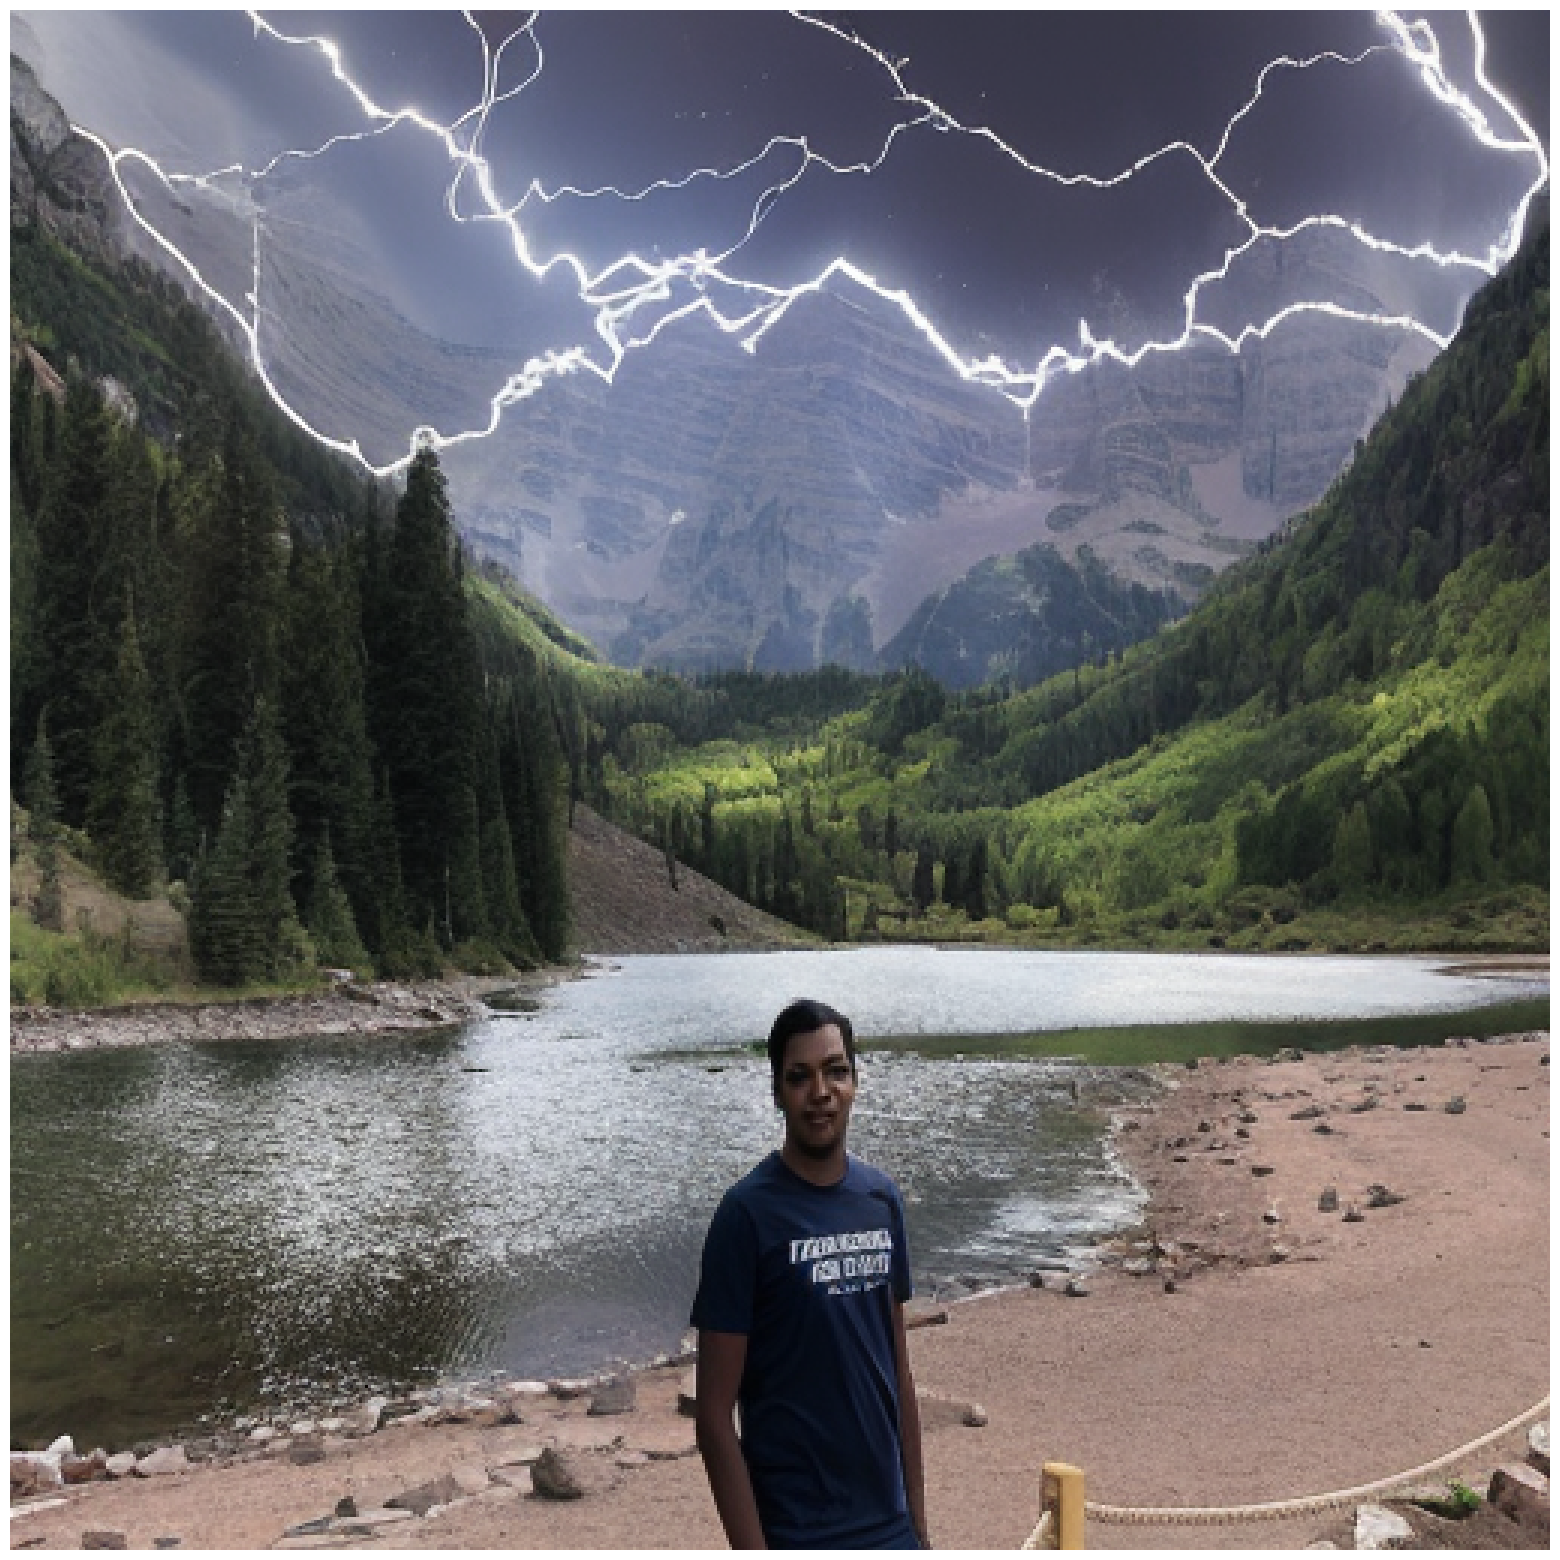

In [77]:
# Diffusion prompts
prompt = 'sky with lightining and thunderstorms'

generator = torch.Generator().manual_seed(0)

### Run stable diffusion pipeline
image_gen = pipeline(
    prompt=prompt,
    image=src_img_cropped_resized,
    mask_image=mask_img,
    guidance_scale=7.5,
    num_inference_steps=50,
    generator=generator,
    output_type="np",
)

# Display masms in the image

plt.figure(figsize=(20,20))
plt.imshow(image_gen.images[0])
plt.axis('off')
plt.show()
